In [1]:
import cv2
import numpy as np
from numpy import array
from lk import DenseMatcherScaleEstimator
from sparse_match import SparseScaleEstimator, RansacScaleEstimator2, RansacScaleEstimator
import os

import pandas as pd
import math

In [2]:
allshit = None

In [3]:
# fx = 718.856
# fy = 718.856
# cx = 607.1928
# cy = 185.2157

import math
angle = 4. * math.pi /180.

T_actual_road = np.array([
    [1, 0., 0.],
    [0., math.cos(angle), -math.sin(angle)],
    [0., math.sin(angle), math.cos(angle)]
])

T_road_actual = np.linalg.inv(T_actual_road)

ideal_norm = np.array([ [0.], [1.], [0.] ])
#ideal_norm = T_actual_road.dot(ideal_norm)


fx = 707.0912
fy = 707.0912
cx = 601.8873
cy = 183.1104

cam_mat = np.array([
        [fx, 0, cx],
        [0, fy, cy],
        [0,  0,  1]
    ])
ROI_dense = np.array([
    [500, 230], [700, 230], [800, 330], [400, 330]
])
ROI_dense = ROI_dense.reshape((-1, 1, 2))

ROI_sparse = np.array([
    [500, 230], [700, 230], [800+40, 380], [400-40, 380]
])
ROI_sparse = ROI_sparse.reshape((-1, 1, 2))

actual_height = 1.7

seq_str = '06'
img_data_dir = '/home/cy/Documents/data/kitti/data_odometry_gray/dataset/sequences/{}/image_0/'.format(seq_str)
gt_file = '/home/cy/Documents/data/kitti/data_odometry_poses/{}.txt'.format(seq_str)

nframes = len([f for f in os.listdir(img_data_dir) if f.endswith(".png")])

df_truth = pd.read_csv(gt_file, sep= ' ', header=None)[[3,7,11]]
df_truth.rename(columns={3:'x', 7:'y', 11:'z'}, inplace=True)
df_truth['translation'] = 1.
for i in range(1, len(df_truth)):
    tx = math.pow(df_truth.iloc[i]['x'] - df_truth.iloc[i-1]['x'], 2) + math.pow(df_truth.iloc[i]['y'] - df_truth.iloc[i-1]['y'], 2) + math.pow(df_truth.iloc[i]['z'] - df_truth.iloc[i-1]['z'], 2) 
    df_truth.at[i, 'translation'] = math.sqrt(tx)

seq = int(seq_str)

sample_idx = 0
fn = str(sample_idx).rjust(6, '0')
fnm1 = str(sample_idx+1).rjust(6, '0')
img1= cv2.imread(os.path.join(img_data_dir,"{}.png".format(fn)), 0).astype('float')
img2= cv2.imread(os.path.join(img_data_dir,"{}.png".format(fnm1)), 0).astype('float')
img1 /= 255.
img2 /= 255.

# [[-0.03108007]
#  [ 0.99932888]
#  [ 0.01938621]]
# n2 = array([[-0.01456786],
#        [ 0.46840554],
#        [ 0.00908671]])
# 3.3931844612668813
# scale using roi: 0.797
# [[0.0636999 ]
#  [0.99793658]
#  [0.00805662]]
# n2 = array([[0.03097199],
#        [0.48521395],
#        [0.00391727]])
# 5.082832637658015
# scale using roi+geo constraints: 0.827
# ground truth scale: 0.8307917549542936

# R = array([[ 9.99993673e-01, -3.47749990e-03,  7.48896327e-04],
#        [ 3.47806029e-03,  9.99993672e-01, -7.48286156e-04],
#        [-7.46289423e-04,  7.50886129e-04,  9.99999440e-01]])

# t = array([[ 0.02089309],
#        [ 0.04358919],
#        [-0.99883105]])


matcher = DenseMatcherScaleEstimator(cam_mat, ROI_dense)
#estimator = SparseScaleEstimator(cam_mat, ROI_sparse, 1.7)
estimator = RansacScaleEstimator2(cam_mat, ROI_sparse, 1.7)
# matcher.optimize_scale(R, t, n2[0, 0], n2[1, 0], n2[2, 0], 0., 50, img1, img2, verbose=True)

In [4]:
start = 751#280#309 #305
end = 900 #311#306
def runall():
    results = []
    hbuffer = []
    timestamps = []
    statistics = []
    
    last_good_n = None
    total_ransac_count = 0

    for i in range(start, end):
#     for i in range(nframes-1):
        try:
            print("processing frame {}".format(i))
            img1 = cv2.imread(os.path.join(img_data_dir, "{}.png".format(str(i).rjust(6, '0'))), 0)
            img2 = cv2.imread(os.path.join(img_data_dir, "{}.png".format(str(i+1).rjust(6, '0'))), 0)

            img1f = img1.astype(float)/255.
            img2f = img2.astype(float)/255.


            cal = estimator.calculate_scale(img1, img2, iterations = 250, accepted_ratio=0.60)
            if cal is None:
                results.append([0, 0])
                statistics.append([0, 0, 0])
            else:
                nunit, n, scale_sparse, R, t, inliers, inliers_ratio, ransac_count = cal
                if ransac_count != 0:
                    total_ransac_count += 1

                gx, gy = matcher.get_image_gradient(img2f)
                gsum = np.sqrt(np.square(gx) + np.square(gy)).sum()

                angle = math.acos(ideal_norm.transpose().dot(n/np.linalg.norm(n)) ) * 180 / math.pi
                print('angle is {} inlier ratio: {}'.format(angle, inliers_ratio))
                if angle > 10. or inliers_ratio < 0.4:
                    raise "error"
#                     results.append([0, 0])
#                     statistics.append([0, 0, 0])

                avg_n = n.copy()
                for idx, nn in enumerate(hbuffer):
                    if i - timestamps[idx] <= 5:
                        avg_n = np.hstack((nn, avg_n))

                count = avg_n.shape[1]
                avg_n = (avg_n.sum(axis=1)/count).reshape((-1, 1))

            #                print(avg_n)
            #                print(n)
            #                 n_opt, scale_dense, sse =  matcher.optimize_scale(R, t, n[0,0], n[1,0], n[2,0], 0, 60, img1f, img2f, verbose=False)
                n_opt, scale_dense, sse =  matcher.optimize_scale(R, t, n[0,0], n[1,0], n[2,0], 0, 50, img1f, img2f, verbose=False)
#                 n_opt, scale_dense, sse =  matcher.optimize_scale(R, t, avg_n[0,0], avg_n[1,0], avg_n[2,0], 0, 50, img1f, img2f, verbose=False)
                angle = math.acos(ideal_norm.transpose().dot(n_opt/np.linalg.norm(n_opt)) ) * 180 / math.pi
                print('dense angle is {}'.format(angle))

                if angle > 20.:
                    raise "error"

                ratio = gsum/sse
                normals_angle = math.acos(nunit.transpose().dot(n_opt/np.linalg.norm(n_opt)) ) * 180 / math.pi

                results.append([scale_sparse, scale_dense])
                statistics.append([ratio, normals_angle, angle])

                hbuffer.append(n_opt)
                timestamps.append(i)
                if len(hbuffer) > 5:
                    hbuffer = hbuffer[1:]
                    timestamps = timestamps[1:]

                    print("buffer size : {}".format(len(hbuffer)))
                
        
        except Exception as e:                
            results.append([0, 0])
            statistics.append([0, 0, 0])
            #print(e)
            #raise e
        
        if nframes % 50 == 0:
            print("Processed {}".format(nframes))
        
        print("-------------------------------------------------")
    
    print("Total ransc count: {}/{}".format(total_ransac_count, end-start))
    return results, statistics

results, statistics = runall()



processing frame 751
Get RT: (4, 1567)
there are 67 points
there are 67 points after filtering
ransac count: 167
angle is 1.9174412890359023 inlier ratio: 0.7014925373134329
dense angle is 1.1395381871252004
-------------------------------------------------
processing frame 752
Get RT: (4, 1570)
there are 31 points
there are 31 points after filtering
ransac count: 104
angle is 4.553637139034177 inlier ratio: 0.7741935483870968
dense angle is 1.9473010573245182
-------------------------------------------------
processing frame 753
Get RT: (4, 1684)
there are 66 points
there are 66 points after filtering
ransac count: 142
angle is 1.597717727788871 inlier ratio: 0.8636363636363636
dense angle is 1.3688668383965368
-------------------------------------------------
processing frame 754
Get RT: (4, 1720)
there are 60 points
there are 60 points after filtering
ransac count: 130
angle is 1.8831321960569207 inlier ratio: 0.7166666666666667
dense angle is 1.3831704034553154
--------------------

Get RT: (4, 1714)
there are 45 points
there are 45 points after filtering
ransac count: 136
angle is 3.099702658438577 inlier ratio: 0.6888888888888889
-------------------------------------------------
processing frame 785
Get RT: (4, 1648)
there are 65 points
there are 65 points after filtering
ransac count: 172
angle is 1.7638345571561138 inlier ratio: 0.8769230769230769
dense angle is 1.5476378401182547
buffer size : 5
-------------------------------------------------
processing frame 786
Get RT: (4, 1516)
there are 55 points
there are 55 points after filtering
ransac count: 160
angle is 3.382344053457217 inlier ratio: 0.6727272727272727
-------------------------------------------------
processing frame 787
Get RT: (4, 1546)
there are 67 points
there are 67 points after filtering
ransac count: 174
angle is 2.861056264584502 inlier ratio: 0.6716417910447762
-------------------------------------------------
processing frame 788
Get RT: (4, 1594)
there are 71 points
there are 71 points

Get RT: (4, 1476)
there are 55 points
there are 55 points after filtering
ransac count: 135
angle is 1.4929574411398001 inlier ratio: 0.8
-------------------------------------------------
processing frame 821
Get RT: (4, 1563)
there are 53 points
there are 53 points after filtering
ransac count: 119
angle is 0.6998132100488345 inlier ratio: 0.7547169811320755
dense angle is 0.8152163829248
buffer size : 5
-------------------------------------------------
processing frame 822
Get RT: (4, 1586)
there are 52 points
there are 52 points after filtering
ransac count: 118
angle is 4.078814840726849 inlier ratio: 0.8076923076923077
dense angle is 3.900718853733698
buffer size : 5
-------------------------------------------------
processing frame 823
Get RT: (4, 1669)
there are 80 points
there are 80 points after filtering
ransac count: 135
angle is 1.6121486886112761 inlier ratio: 0.625
-------------------------------------------------
processing frame 824
Get RT: (4, 1678)
there are 78 points

Get RT: (4, 1526)
there are 61 points
there are 61 points after filtering
ransac count: 145
angle is 4.379568235606044 inlier ratio: 0.639344262295082
dense angle is 4.477165935067843
buffer size : 5
-------------------------------------------------
processing frame 854
Get RT: (4, 1526)
there are 78 points
there are 78 points after filtering
ransac count: 148
angle is 1.1633052004824997 inlier ratio: 0.6538461538461539
dense angle is 1.5225637501537883
buffer size : 5
-------------------------------------------------
processing frame 855
Get RT: (4, 1544)
there are 75 points
there are 75 points after filtering
ransac count: 110
angle is 3.412747527238821 inlier ratio: 0.8533333333333334
dense angle is 2.8021868630268627
buffer size : 5
-------------------------------------------------
processing frame 856
Get RT: (4, 1492)
there are 83 points
there are 83 points after filtering
ransac count: 130
angle is 3.2006000199517795 inlier ratio: 0.8192771084337349
dense angle is 2.937898144763

dense angle is 1.4455998602236508
buffer size : 5
-------------------------------------------------
processing frame 885
Get RT: (4, 1363)
there are 11 points
there are 11 points after filtering
ransac count: 136
angle is 4.349211822808602 inlier ratio: 0.8181818181818182
-------------------------------------------------
processing frame 886
Get RT: (4, 1357)
there are 62 points
there are 62 points after filtering
ransac count: 122
angle is 2.0938067112425713 inlier ratio: 0.8225806451612904
dense angle is 2.190384462776965
buffer size : 5
-------------------------------------------------
processing frame 887
Get RT: (4, 1432)
there are 64 points
there are 64 points after filtering
ransac count: 134
angle is 2.4879078873815423 inlier ratio: 0.796875
dense angle is 2.028196708547924
buffer size : 5
-------------------------------------------------
processing frame 888
Get RT: (4, 1348)
there are 62 points
there are 62 points after filtering
ransac count: 115
angle is 3.1567066138649693 

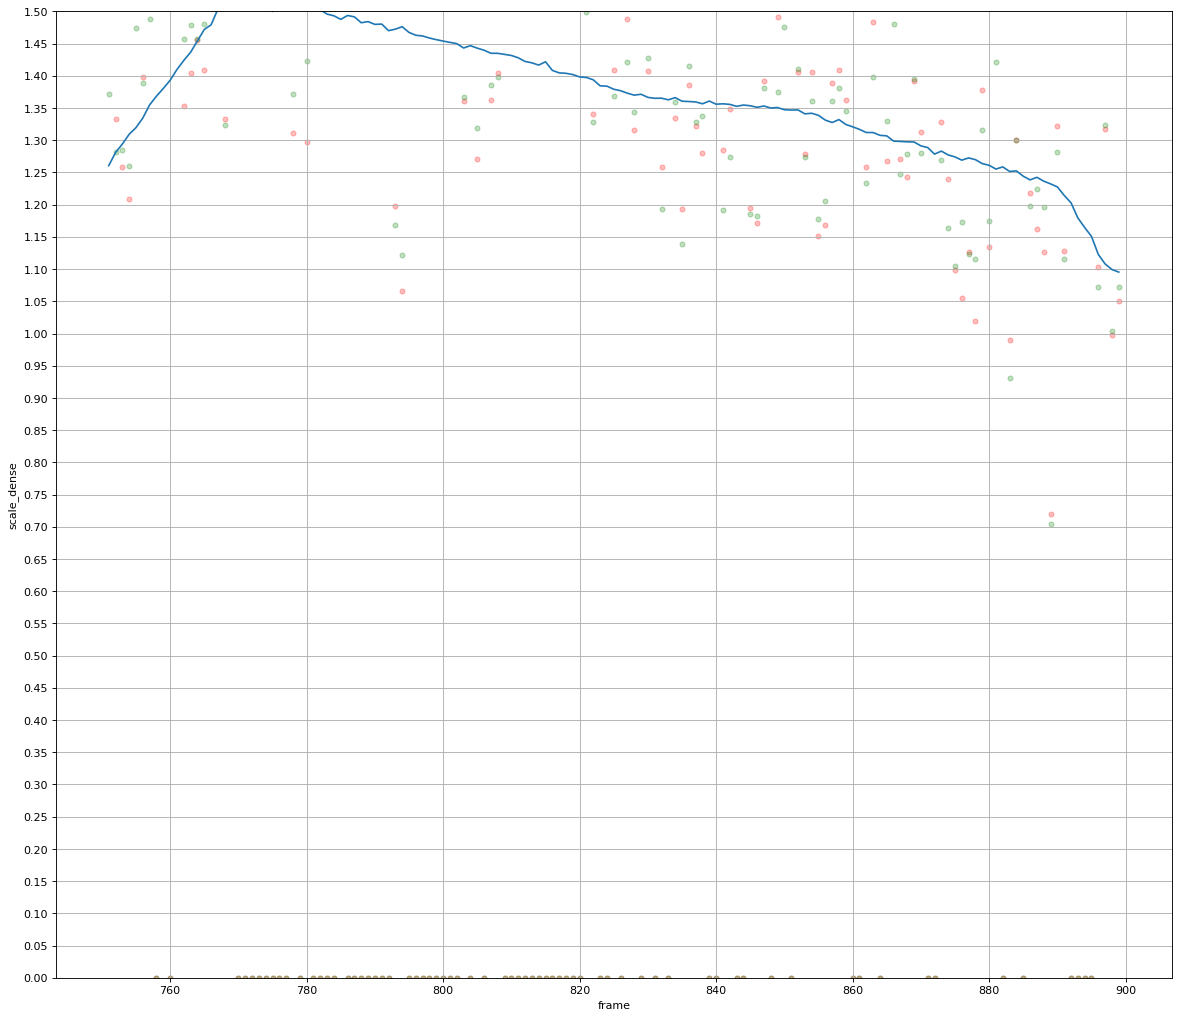

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.gca()
plt.yticks(np.arange(0, 2, 0.05))
plt.ylim(0, 1.5)

results2 = np.array(results)
df = pd.DataFrame({'scale_roi': results2[:,0], 
                   'scale_dense': results2[:,1], 
                    'frame': np.arange(start, end)
                  })

df_truth[start:end]['translation'].plot(ax=ax, label='Ground truth', grid=True)
df.plot.scatter(x='frame', y='scale_roi', c='r', ax=ax, alpha=.25, grid=True)
df.plot.scatter(x='frame', y='scale_dense', c='g', ax=ax, alpha=.25, grid=True)

In [6]:
results = pd.concat([df.set_index('frame'), df_truth[start:end]['translation']], axis=1, sort=False)
valid_results = results[results['scale_dense'] != 0]
err = (valid_results['scale_dense'] - valid_results['translation'])**2
print("rmse: {}".format(np.sqrt(err.mean())))
print("total valid: {}".format(valid_results.shape[0]))

rmse: 0.12856820946093053
total valid: 82


In [7]:
df

,scale_roi,scale_dense,frame
0,1.508822,1.371139,751
1,1.333153,1.282437,752
2,1.258130,1.284309,753
3,1.209332,1.260081,754
4,1.574059,1.474349,755
...,...,...,...
144,0.000000,0.000000,895
145,1.102863,1.072143,896
146,1.318125,1.323326,897
147,0.997094,1.004643,898


In [8]:
df_truth[start:end]['translation']

751    1.260507
752    1.280942
753    1.294055
754    1.309313
755    1.319607
         ...   
895    1.150747
896    1.122732
897    1.107944
898    1.099328
899    1.095323
Name: translation, Length: 149, dtype: float64

In [9]:
results

,scale_roi,scale_dense,translation
751,1.508822,1.371139,1.260507
752,1.333153,1.282437,1.280942
753,1.258130,1.284309,1.294055
754,1.209332,1.260081,1.309313
755,1.574059,1.474349,1.319607
...,...,...,...
895,0.000000,0.000000,1.150747
896,1.102863,1.072143,1.122732
897,1.318125,1.323326,1.107944
898,0.997094,1.004643,1.099328
